In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve 
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score, confusion_matrix

from collections import Counter

from helper import clean_churn_df, model_baseline, model_baseline_no_cv, score_model_no_cv, score_model
from helper import split_with_dupe_rows_in_train, rf_no_cv_iterx

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

from sqlalchemy import create_engine

plt.style.use('ggplot')
%matplotlib inline


%config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2


In [2]:
from sqlid import sql_id
engine = create_engine(sql_id()) #stored my unique SQL identifier in a variable, set 

churn_df = pd.read_sql_query('select * from hr',con=engine)  
churn_df.drop('index', axis=1,inplace=True)
X_train, X_val, X_holdout, y_train, y_val, y_holdout = split_with_dupe_rows_in_train(churn_df)

In [3]:
# add improvements from feature engineering
X_train['hours_eval'] = X_train['average_montly_hours'] * X_train['last_evaluation']
X_val['hours_eval'] = X_val['average_montly_hours'] * X_val['last_evaluation']

In [4]:
model_baseline_no_cv(X_train,y_train,X_val, y_val)

(0.650887573964497,
 0.7677725118483413,
 0.3218029350104822,
 0.38875878220140514,
 0.8961748633879781,
 0.9856733524355301)

In [5]:
rf = RandomForestClassifier(random_state=41)
rf.fit(X_train,y_train)
print("kNN confusion matrix: \n\n", confusion_matrix(y_val, rf.predict(X_val)))

kNN confusion matrix: 

 [[1634    5]
 [  17  344]]


ROC AUC score =  0.9883999601135076


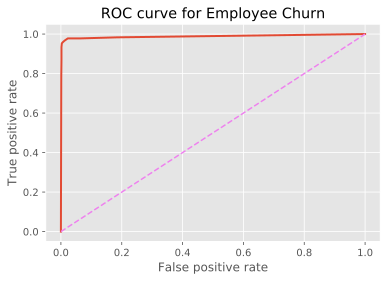

In [6]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_val, rf.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Employee Churn');
print("ROC AUC score = ", roc_auc_score(y_val, rf.predict_proba(X_val)[:,1]))

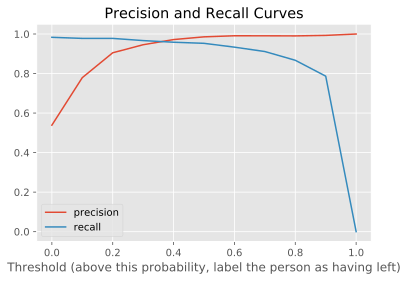

In [7]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, rf.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label the person as having left)');
plt.title('Precision and Recall Curves');